In [4]:
# Instalar as bibliotecas necessárias
!pip install tensorflow -q

In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

print(f"TensorFlow version: {tf.__version__}")
print(f"OpenCV version: {cv2.__version__}")

2025-10-14 20:13:09.128491: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0
OpenCV version: 4.12.0


# Classificação de Gatos e Cachorros com CNN

Este notebook implementa um modelo de classificação de imagens usando TensorFlow/Keras para distinguir entre gatos e cachorros.


In [6]:
# Definir caminhos do dataset
base_path = 'farmtech_yolo_project/dataset'
train_path = os.path.join(base_path, 'train/images')
test_path = os.path.join(base_path, 'test/images')
valid_path = os.path.join(base_path, 'valid/images')

# Verificar se os diretórios existem
print(f"Train path exists: {os.path.exists(train_path)}")
print(f"Test path exists: {os.path.exists(test_path)}")
print(f"Valid path exists: {os.path.exists(valid_path)}")


Train path exists: True
Test path exists: True
Valid path exists: True


In [7]:
# Função para carregar imagens e labels
def load_images_and_labels(images_path, img_size=(128, 128)):
    """
    Carrega imagens do diretório e cria labels baseado no nome do arquivo
    cat.*.jpg -> label 0
    dog.*.jpg -> label 1
    """
    images = []
    labels = []
    
    # Listar todos os arquivos no diretório
    files = sorted(os.listdir(images_path))
    
    for filename in files:
        if filename.endswith('.jpg'):
            # Carregar e processar a imagem
            img_path = os.path.join(images_path, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Converter BGR para RGB
            img = cv2.resize(img, img_size)
            
            # Garantir que a imagem está em RGB (3 canais)
            if len(img.shape) == 2:  # Se for grayscale
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            
            images.append(img)
            
            # Criar label baseado no nome do arquivo
            if filename.startswith('cat'):
                labels.append(0)  # Gato = 0
            elif filename.startswith('dog'):
                labels.append(1)  # Cachorro = 1
    
    return np.array(images), np.array(labels)

print("Função de carregamento criada!")

Função de carregamento criada!


In [8]:
# Carregar o dataset
print("Carregando dataset...")

train_images, train_labels = load_images_and_labels(train_path)
test_images, test_labels = load_images_and_labels(test_path)
valid_images, valid_labels = load_images_and_labels(valid_path)

print()
print(f"Train images shape: {train_images.shape}")
print(f"Train labels: {len(train_labels)}")
print(f"Train labels content: {train_labels}")
print()
print(f"Test images shape: {test_images.shape}")
print(f"Test labels: {len(test_labels)}")
print()
print(f"Valid images shape: {valid_images.shape}")
print(f"Valid labels: {len(valid_labels)}")


Carregando dataset...

Train images shape: (64, 128, 128, 3)
Train labels: 64
Train labels content: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Test images shape: (8, 128, 128, 3)
Test labels: 8

Valid images shape: (8, 128, 128, 3)
Valid labels: 8


In [9]:
# Salva as classes
class_names = ['Cat', 'Dog']
print(f"Classes: {class_names}")


Classes: ['Cat', 'Dog']


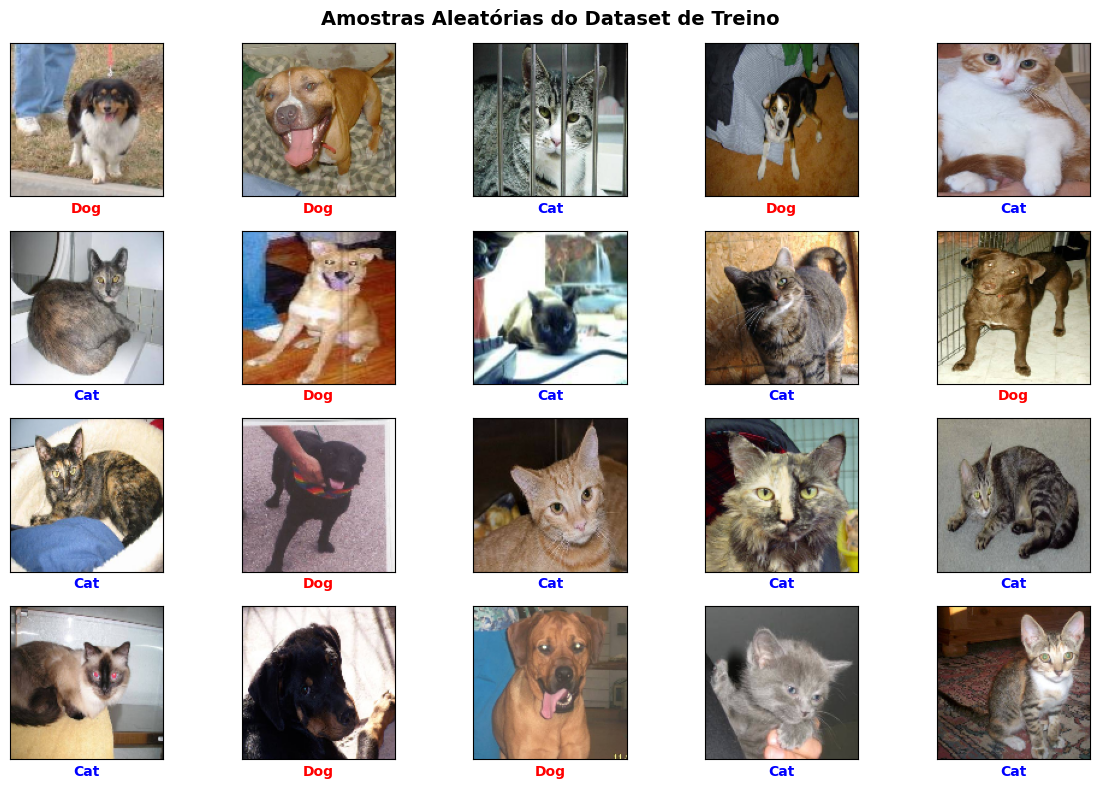

In [11]:
# Exibir algumas imagens aleatórias do dataset de treino
plt.figure(figsize=(12, 8))
num_images = min(20, len(train_images))

# Gerar índices aleatórios para as imagens
random_indices = np.random.choice(len(train_images), num_images, replace=False)

for i, idx in enumerate(random_indices):
    plt.subplot(4, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[idx])
    
    # Adicionar rótulo colorido
    if train_labels[idx] == 0:  # Gato
        color = 'blue'
    else:  # Cachorro
        color = 'red'
    
    plt.xlabel(class_names[train_labels[idx]], color=color, fontweight='bold')

plt.suptitle('Amostras Aleatórias do Dataset de Treino', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [12]:
# Normalizar os dados
# Toda imagem é representada por uma matriz de pixels que vai de 0 a 255
# Redes neurais funcionam melhor com valores de 0 a 1 ou -1 a 1.
# Então vamos dividir os valores da matriz por 255 para ter uma escala de 0 a 1
train_images = train_images / 255.0
test_images = test_images / 255.0
valid_images = valid_images / 255.0

print("Imagens normalizadas!")
print(f"Train images range: [{train_images.min():.2f}, {train_images.max():.2f}]")


Imagens normalizadas!
Train images range: [0.00, 1.00]


## Modelo utilizando TensorFlow/Keras


In [13]:
# Definição da semente de aleatoriedade
tf.random.set_seed(42)

# Define o modelo CNN (Convolutional Neural Network)
model = keras.Sequential([
    # Camada de entrada
    keras.layers.Input(shape=(128, 128, 3)),
    
    # Primeira camada convolucional
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    
    # Segunda camada convolucional
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    
    # Terceira camada convolucional
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    
    # Achatamento
    keras.layers.Flatten(),
    
    # Camadas densas
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),  # Dropout para evitar overfitting
    
    # Camada de saída (2 classes: cat, dog)
    keras.layers.Dense(2, activation='softmax')
])

# Compilar o modelo
model.compile(
    optimizer='adam',  # Algoritmo de otimização
    loss='sparse_categorical_crossentropy',  # Função de perda para classificação
    metrics=['accuracy']  # Métrica para avaliar
)

print("Modelo criado e compilado!")


Modelo criado e compilado!


2025-10-14 20:14:59.599146: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [14]:
# O que tem neste modelo? Exibir a arquitetura do modelo
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Treinamento do modelo
print("Iniciando treinamento...")
history = model.fit(
    train_images, 
    train_labels, 
    epochs=20,
    validation_data=(valid_images, valid_labels),
    batch_size=8
)
print("Treinamento concluído!")


Iniciando treinamento...
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.4844 - loss: 0.7634 - val_accuracy: 0.5000 - val_loss: 0.7100
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.4844 - loss: 0.7634 - val_accuracy: 0.5000 - val_loss: 0.7100
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5000 - loss: 0.7144 - val_accuracy: 0.8750 - val_loss: 0.6887
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5000 - loss: 0.7144 - val_accuracy: 0.8750 - val_loss: 0.6887
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6250 - loss: 0.6911 - val_accuracy: 0.5000 - val_loss: 0.6688
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.6250 - loss: 0.6911 - val_accuracy: 0.5000 - val_loss: 0.6688
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6094 - loss: 0.6653 - val_accuracy: 0.7500 - val_loss: 0.6672
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6094 - loss: 0.6653 - val_accuracy: 0

In [16]:
# Avaliação do modelo com o conjunto de teste
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print()
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


1/1 - 0s - 136ms/step - accuracy: 0.7500 - loss: 0.4021

Test Loss: 0.4021
Test Accuracy: 0.7500

Test Loss: 0.4021
Test Accuracy: 0.7500


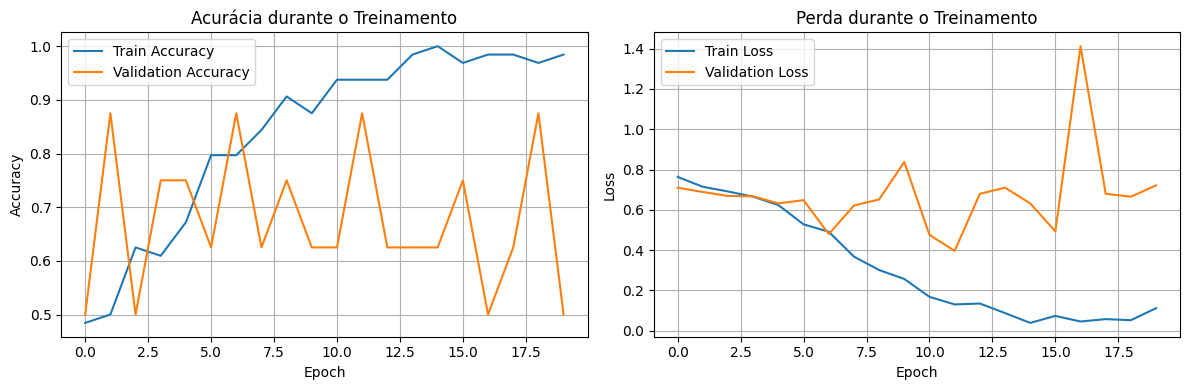

In [17]:
# Visualizar histórico de treinamento
plt.figure(figsize=(12, 4))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Acurácia durante o Treinamento')
plt.grid(True)

# Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Perda durante o Treinamento')
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


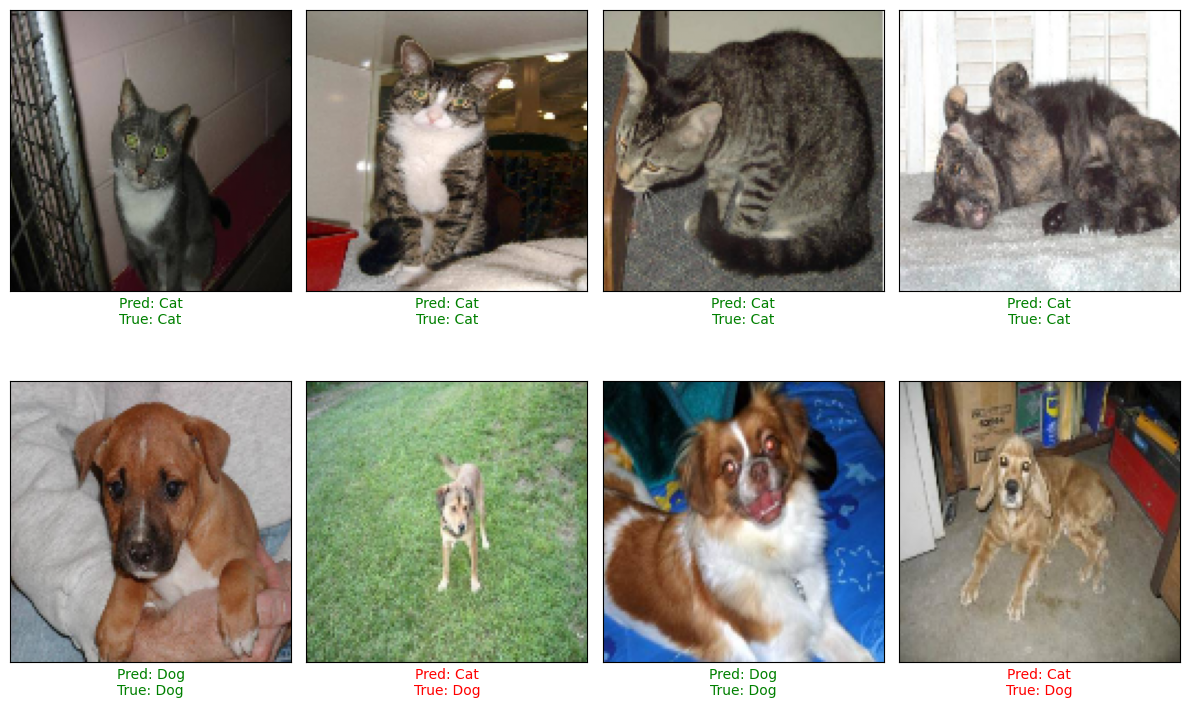

In [18]:
# Fazer predições em algumas imagens de teste
predictions = model.predict(test_images)

# Visualizar predições
plt.figure(figsize=(12, 8))
num_images = min(8, len(test_images))
for i in range(num_images):
    plt.subplot(2, 4, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i])
    
    predicted_label = np.argmax(predictions[i])
    true_label = test_labels[i]
    
    # Cor verde se correto, vermelho se errado
    color = 'green' if predicted_label == true_label else 'red'
    
    plt.xlabel(f"Pred: {class_names[predicted_label]}\nTrue: {class_names[true_label]}", 
               color=color)

plt.tight_layout()
plt.show()


## Resumo do Modelo

Este notebook implementou um modelo CNN (Convolutional Neural Network) para classificação de imagens de gatos e cachorros usando TensorFlow/Keras.

### Arquitetura do Modelo:
- **Camadas Convolucionais**: 3 camadas conv2D com filtros 32, 64 e 128
- **Pooling**: MaxPooling após cada convolução para redução dimensional
- **Camada Densa**: 128 neurônios com ativação ReLU
- **Dropout**: 0.5 para regularização
- **Saída**: 2 neurônios (cat/dog) com ativação softmax

### Dataset:
- **Training**: 64 imagens (32 gatos + 32 cachorros)
- **Validation**: 8 imagens (4 gatos + 4 cachorros)
- **Test**: 8 imagens (4 gatos + 4 cachorros)

### Pré-processamento:
- Redimensionamento para 128x128 pixels
- Normalização (valores entre 0 e 1)
- Conversão para RGB (3 canais)

### Parâmetros de Treinamento:
- **Epochs**: 20
- **Batch Size**: 8
- **Optimizer**: Adam
- **Loss Function**: Sparse Categorical Crossentropy
